<h1>sum_emissions</h1>
<h3>Notebook for printing emissions totals from HEMCO diagnostic netCDF files</h3>

We only need to import a few packages. The os.path package is used for filename manipulation, xarray for manipulationg netCDF data, and numpy for math operations

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


Define the data file that you want to read.  We will sum emissions for each of the variables within this file.


In [22]:
# We will use the January 2016 data file as an example.
filename = '../../GCrundirs/standalone_monthly/hemco_4x5_geosfp/OutputDir/HEMCO_sa_diagnostics.201601020000.nc'

# Year and month 
year  = 2016
month = 1

# Seconds in January 2016
sec_in_month = 31.0 * 86400.0 

We will read the entire contents of the netCDF file into an xarray Dataset object.  The very powerful xarray package allows you to easily read and manipulate Earth Science data that are stored in netCDF files.

In [23]:
# Load the netCDF file into an xarray dataset
ds = xr.open_mfdataset(filename)

# Show the contents of the xarray dataset object.
# In Jupyter notebook, typing the name of a variable or object
# on the last line of a cell prints the object.
ds

<xarray.Dataset>
Dimensions:              (lat: 46, lev: 47, lon: 72, time: 1)
Coordinates:
  * lon                  (lon) float64 -180.0 -175.0 -170.0 ... 170.0 175.0
  * lat                  (lat) float64 -89.0 -86.0 -82.0 ... 82.0 86.0 89.0
  * lev                  (lev) float64 0.9925 0.9775 ... 0.0001387 3.8e-05
  * time                 (time) datetime64[ns] 2016-01-02
Data variables:
    hyam                 (lev) float64 dask.array<shape=(47,), chunksize=(47,)>
    hybm                 (lev) float64 dask.array<shape=(47,), chunksize=(47,)>
    P0                   float64 ...
    AREA                 (lat, lon) float64 dask.array<shape=(46, 72), chunksize=(46, 72)>
    EmisXYLE_Ship        (time, lat, lon) float32 dask.array<shape=(1, 46, 72), chunksize=(1, 46, 72)>
    EmisXYLE_BioBurn     (time, lat, lon) float32 dask.array<shape=(1, 46, 72), chunksize=(1, 46, 72)>
    EmisXYLE_Anthro      (time, lev, lat, lon) float32 dask.array<shape=(1, 47, 46, 72), chunksize=(1, 47, 46, 72

Extract the grid box surface area values from the HEMCO diagnostic file.  Surface area is stored in each HEMCO diagnostic file as a 2-dimensional (lon,lat) variable named "AREA".

In [24]:
# Extract the grid box surface area values f(in units of m^2) 
# from the xarray Dataset object into a numpy array.
# This is done by using with the .values tag.
area = ds['AREA'].values 

# Print the shape of the area array
print( "Original shape of AREA: {}".format( area.shape ) )

# Reshape area from (46,72) to (1,46,72) to be consistent with the 
# emissions data variables in the file.  If the array shapes are the same,
# we can multiply each emissions data array directly by the area array.
area = area[ np.newaxis, :, : ]

# Print the new of the area array
print( "New shape of AREA: {}".format( area.shape ) )

Original shape of AREA: (46, 72)
New shape of AREA: (1, 46, 72)


Construct the list of variables for which emissions totals will be printed.

In [25]:
# List of all variables in the xarray object.
# This will include the index arrays (lon, lat, time) and also the AREA variable.
varlist = ['EmisNO_Anthro', 'EmisNO2_Anthro']#ds.data_vars.keys()

# Restrict the list of variables to only those containing emissions data.
# (i.e. those that have at least 3 dimensions (e.g. time,lat.lon).
# To manipulate a list, we have to use the "v for v in varlist if ..." syntax.
varlist = [v for v in varlist if ds[v].ndim > 2  ]

# Print the modified list.  This now only contains emisisons variables.
varlist

['EmisNO_Anthro', 'EmisNO2_Anthro']

Loop over each emissions variable in the list and print the emission totals.

In [26]:
n_no2 = 14.0067 / 46.0055 
n_no = 14.0067 / 30.01
tons_kg = 0.00110231
emissions = pd.DataFrame(index = varlist, columns = ['short tons N', 'kg N', 'kg'])
for name in varlist:
    
    # Get the units of each data variable.
    # This will typically be in either kg/m2/s or kgC/m2/s, depending on the variable.
    units = ds[name].units
    
    # We are going to print emissions totals in kg, so let's strip off just the
    # kg or kgC part from the units name.  We do this the string "split()" method.
    units = units.split( "/" )
    
    # units.split will return an array of substrings.  We just want the first element.
    units = units[0]
    
    # Extract the data from the "ds" xarray object into a numpy array object.
    emissions_array = ds[name].values
    
    # Convert the emissions data to kg/m2/s and take the sum
    emissions_sum = np.sum( emissions_array * area * sec_in_month )
    emissions.loc[name]['kg'] = emissions_sum
    # Convert to kg N
    if name is 'EmisNO_Anthro':
        emissions_N = emissions_sum * n_no
    if name is 'EmisNO2_Anthro':
        emissions_N = emissions_sum * n_no2
    emissions.loc[name]['kg N'] = emissions_N
    #convert to short tons
    emissions.loc[name]['short tons N'] = (emissions_N * tons_kg)
    
    # Print the emissions total. The  " .6e" specifier requests a number in 
    # scientific notation with 6 decimal places.  We leave a space for the - sign.
    # The string method ".ljust(x)" will left-justify a string in a column x spaces wide.
    print( "{n} sum = {es: .6e}  {u}".format( n=name.ljust(15), es=emissions_N, u=units ) )


EmisNO_Anthro   sum =  1.681162e+08  kg
EmisNO2_Anthro  sum =  1.917840e+07  kg


In [27]:
NOx_conc_new = emissions['short tons N'].sum()

# Import reference data

In [28]:
monthlycounty2016 = pd.read_csv('./2016fh_county_monthly_report_22jan2020_v0.csv', comment='#')

In [29]:
np.unique(monthlycounty2016['census_tract_cd'])

array(['afdust_adj', 'ag', 'airports', 'beis', 'cmv_c1c2_12', 'cmv_c3_12',
       'nonpt', 'nonroad', 'np_oilgas', 'onroad', 'onroad_ca_adj',
       'pt_oilgas', 'ptagfire', 'ptegu', 'ptfire', 'ptnonipm', 'rail',
       'rwc'], dtype=object)

In [30]:
month_abbrev = ['jan','feb','mar','apr','may','jun','jul','aug','sep','nov','dec']
month_value = [f'{month}_value' for month in month_abbrev]
month_value.append('ann_value')

In [31]:
NOx_ref = monthlycounty2016.loc[
    monthlycounty2016['poll'] == 'NOX'].groupby(
    'census_tract_cd').sum()['jan_value'].drop(
    ['beis','ptfire','ptagfire', 'cmv_c1c2_12','cmv_c3_12']).sum()*n_no2 #is this in tons N already? otherwise converting it gets unreasonable values

In [32]:
print('EPA 2016 to reference:\n', 'EPA 2016: ', NOx_conc_new, 'short tons\n', 'Reference: ', NOx_ref, 'short tons\n', NOx_conc_new/NOx_ref*100, '%')

EPA 2016 to reference:
 EPA 2016:  206456.74241161245 short tons
 Reference:  239470.17992714213 short tons
 86.21396721480149 %


# Plots

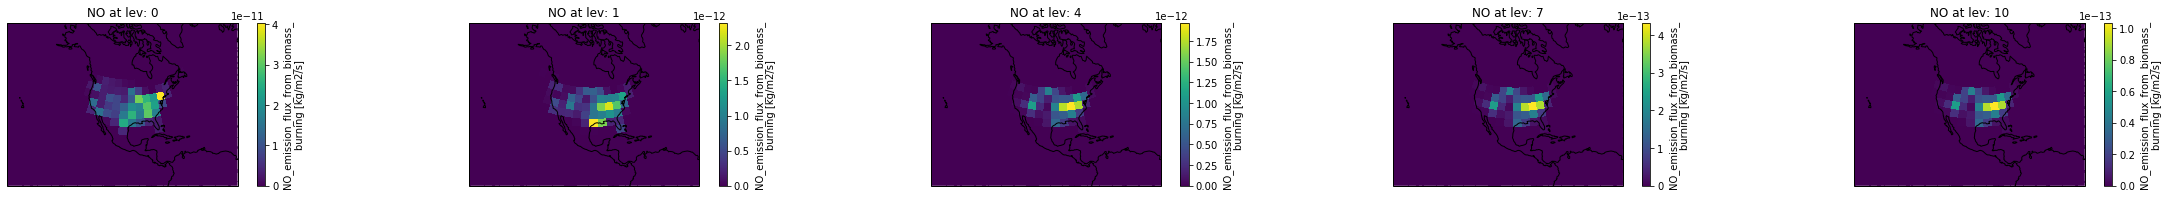

In [117]:
fig, axes = plt.subplots(1,5, figsize = [40,3], subplot_kw={'projection':ccrs.LambertConformal()})
for idx, lev in enumerate([0,1,4,7,10]):
    ax = axes[idx]
    ds['EmisNO_Anthro'].isel(lev = lev).plot(ax = ax, transform = ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'NO at lev: {lev}')

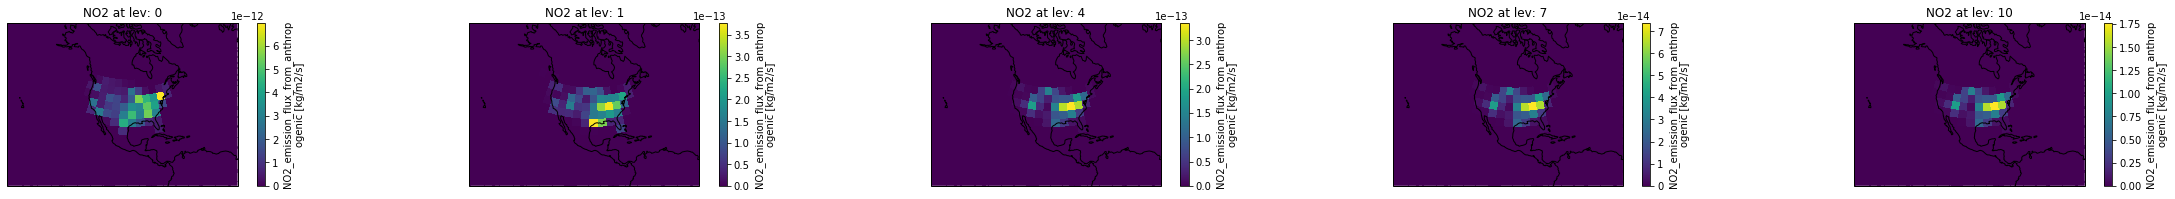

In [120]:
fig, axes = plt.subplots(1,5, figsize = [40,3], subplot_kw={'projection':ccrs.LambertConformal()})
for idx, lev in enumerate([0,1,4,7,10]):
    ax = axes[idx]
    ds['EmisNO2_Anthro'].isel(lev = lev).plot(ax = ax, transform = ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-150, -50, 0, 70])
    ax.set_title(f'NO2 at lev: {lev}')